In [1]:
import os
import pickle
import glob
import gzip
from tqdm.notebook import tqdm #from tqdm import tqdm_notebook as tqdm
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import defusedxml.ElementTree as ET
from collections import OrderedDict
import collections
from collections import Counter
import datetime


In [2]:
os.getcwd()

'/home/admin_user'

In [3]:
path_1= '/home/admin_user/デスクトップ/folder_04'
path_2= '/home/admin_user/デスクトップ/folder_05'

os.chdir(path_1)
csv_list = sorted(glob.glob('*.csv'))
#print(len(csv_list), csv_list)

In [4]:
#疾患 読み込み
disease = pd.read_csv('disease.csv', engine='python')
#症状 読み込み
symptom = pd.read_csv('symptom.csv', engine='python')

#処理時間は同じくらい
#import dask.dataframe as dd
#dd.read_csv('disease.csv').compute() 

In [5]:
print("疾患 MajorTopicの確認")
print(disease[disease["Descriptor_MajorTopic"]=="Y"]["Qualifier_MajorTopic"].unique().tolist())
print(disease[disease["Descriptor_MajorTopic"]=="N"]["Qualifier_MajorTopic"].unique().tolist())

print("症状 MajorTopicの確認")
print(symptom[symptom["Descriptor_MajorTopic"]=="Y"]["Qualifier_MajorTopic"].unique().tolist())
print(symptom[symptom["Descriptor_MajorTopic"]=="N"]["Qualifier_MajorTopic"].unique().tolist())

疾患 MajorTopicの確認
[nan, 'N', 'Y']
['Y']
症状 MajorTopicの確認
[nan, 'N', 'Y']
['N', 'Y', nan]


In [6]:
print("疾患", disease["PubDate"].min(), disease["PubDate"].max())
print("症状", symptom["PubDate"].min(), symptom["PubDate"].max())

疾患 1902-03-01 2020-12-01
症状 1940-06-08 2020-11-29


In [7]:
#update
update_disease = disease[ disease["PubDate"]>="1966-01-01" ]
update_symptom = symptom[ symptom["PubDate"]>="1966-01-01" ]
update_disease.to_csv("update_disease.csv", index=False)
update_symptom.to_csv("update_symptom.csv", index=False)

In [8]:
#update版の基礎統計

In [9]:
df_list = ["update_disease", "update_symptom"]
#PMID数, PubDate
for i in df_list:
    print(i,  ":", eval(i)["PMID"].nunique(), eval(i)["PubDate"].min(), eval(i)["PubDate"].max())

update_disease : 12423905 1966-01-01 2020-12-01
update_symptom : 1976200 1966-01-01 2020-11-29


In [10]:
#mesh数 
#Descriptor, Descriptor_UI 同じ数だった

#disease
print("update_disease_MeSH: ", update_disease["Descriptor"].nunique() )
print("update_symptom_MeSH: ", update_symptom["Descriptor"].nunique() )

update_disease_MeSH:  4828
update_symptom_MeSH:  384


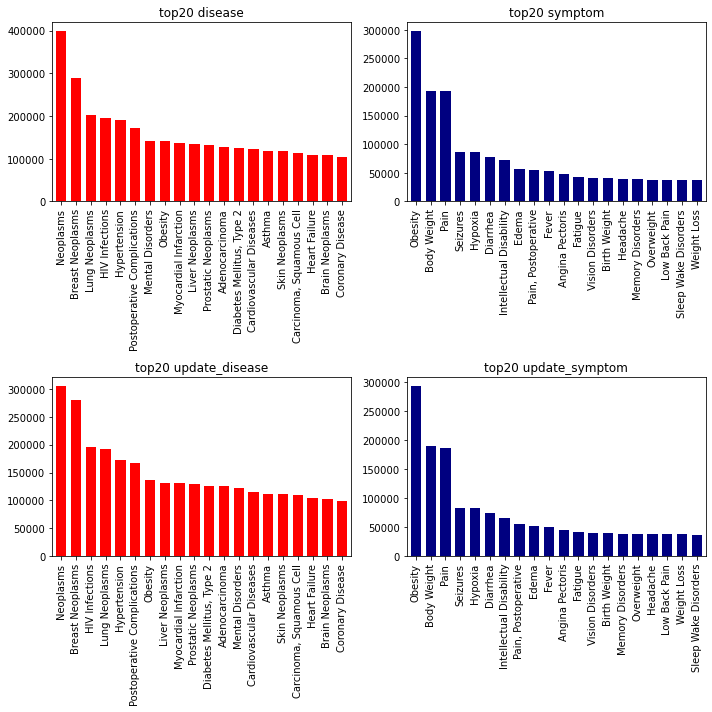

In [11]:
#共起ペアにする前の様子

#疾患メッシュ症状メッシュの出現数top20 

import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))

color_1 = 'red'
color_2 = 'navy'

#disease, symptom
plt.subplot(221)
disease["Descriptor"].value_counts()[:20].plot.bar(width=0.7, color=color_1, title='top20 disease')#alpha=0.5
plt.subplot(222)
symptom["Descriptor"].value_counts()[:20].plot.bar(width=0.7, color=color_2, title='top20 symptom')

#update_disease, update_symptom
plt.subplot(223)
update_disease["Descriptor"].value_counts()[:20].plot.bar(width=0.7, color=color_1, title='top20 update_disease')#alpha=0.5
plt.subplot(224)
update_symptom["Descriptor"].value_counts()[:20].plot.bar(width=0.7, color=color_2, title='top20 update_symptom')

plt.tight_layout()
plt.show()

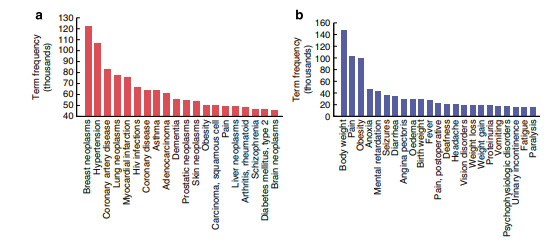

In [12]:
from IPython.display import Image
Image("/home/admin_user/キャプチャbarabasi.PNG")

In [13]:
# update_disease, update_symptom

# disease | symptom 文献数
print(len(sorted(list(set(update_disease["PMID"]) | set(update_symptom["PMID"])))))

# disease & symptom 文献数
print(len(sorted(list(set(update_disease["PMID"]) & set(update_symptom["PMID"])))))


12890258
1509847


In [14]:
update_d = update_disease[["PMID","PubDate","Descriptor"]]
update_s = update_symptom[["PMID","PubDate","Descriptor"]]

update_d = update_d.rename(columns={"Descriptor":"disease"})
update_s = update_s.rename(columns={"Descriptor":"symptom"})

each_ds_pair = pd.merge(update_d, update_s, on=["PMID", "PubDate"])


In [15]:
#save to csv
os.chdir(path_2)
each_ds_pair.to_csv("each_ds_pair.csv", index=False)

In [16]:
each_ds_pair[:5]

PMID     PubDate                      disease    symptom
0   123  1975-10-01            Duodenal Diseases  Heartburn
1   123  1975-10-01                    Gastritis  Heartburn
2   123  1975-10-01  Postoperative Complications  Heartburn
3   127  1975-11-29                    Poisoning   Vomiting
4   210  1975-07-01          Acid-Base Imbalance    Hypoxia

In [22]:
print("ペア出現数: ", len(each_ds_pair))
print("ペアの種類数: ", len(each_ds_pair[["disease", 'symptom']].value_counts()))
print("diseaseの種類数: ", each_ds_pair["disease"].nunique())
print("symptomの種類数: ", each_ds_pair["symptom"].nunique())

ペア出現数:  5632191
ペアの種類数:  211838
diseaseの種類数:  4716
symptomの種類数:  384


#共起ペア 基礎統計

import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
#疾患メッシュ top20
plt.subplot(131)
each_ds_pair["disease"].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='red', title='top20 disease terms')
#症状メッシュ top20
plt.subplot(132)
each_ds_pair["symptom"].value_counts()[:20].plot.bar(width=0.7, color="navy", title='top20 symptom terms')
#共起ペア top20
plt.subplot(133)
each_ds_pair[["symptom", "disease"]].value_counts()[:20].plot.bar(width=0.7, alpha=0.6, color='green', title='top20 pairs')

plt.tight_layout()
plt.show()